# SPamCo with Ensembles

In [60]:
#Math packages
import numpy as np

#Spamco
from spamco import SPamCo, Validation

#Data packages
from sklearn.datasets import make_moons, make_classification, make_circles, make_blobs, make_gaussian_quantiles
from sklearn.datasets import load_breast_cancer, load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#Classifier packages
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

#Validation packages
from sklearn.metrics import accuracy_score

#Visualization packages
import plotly.express as px

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as plb
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import ListedColormap

import baycomp

#General utility packages
from itertools import cycle, islice
import warnings

warnings.filterwarnings("ignore")
matplotlib.rcParams.update({'font.size': 20})

## Utility functions for experiments

### Generate data for toy experiments



In [2]:
###Generate data for Binary Classification
def make_2class(random_seed, n, return_X_y=False):
    np.random.seed(random_seed) 
    X,y = make_blobs(n_samples=200, centers=2, cluster_std=0.7)
    X[:,0] -= 9.3
    X[:,1] -= 2.5

    np.random.seed(1)
    pos_ids = np.where(y == 0)[0]
    neg_ids = np.where(y == 1)[0]
    ids1 = np.random.randint(0,len(pos_ids),5)
    ids2 = np.random.randint(0,len(neg_ids),5)
    p1 = pos_ids[ids1]
    p2 = neg_ids[ids2]

    ## generate labeled and unlabeled data
    l_ids = np.concatenate((p1 , p2))
    u_ids = np.array(list(set(np.arange(X.shape[0])) - set(l_ids)))
    l_data1, l_data2 = X[l_ids,0].reshape(-1,1), X[l_ids,1].reshape(-1,1)
    u_data1, u_data2 = X[u_ids,0].reshape(-1,1), X[u_ids,1].reshape(-1,1)
    labels = y[l_ids]
    
    if return_X_y:
        return X, y
    else:
        return [l_data1, l_data2], [u_data1, u_data2], labels, X, y, [p1, p2]

Random Forest Classifier: 0.99000
SPamCo + Random Forest Classifier: 0.83000


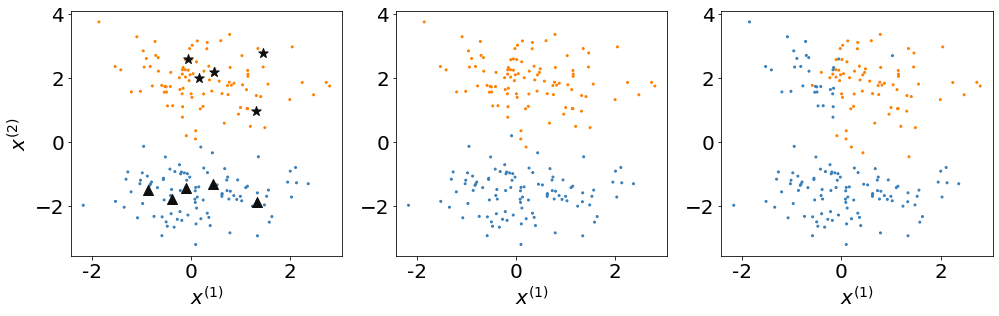

In [3]:
x = [-1.5,0,1.5]
my_xticks=[-2,0,2]

### Get data
ldata, udata, labels, X, y, label_ids = make_2class(4, 200)

### parameters
steps = 1
gamma = 3

### original fig
colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y) + 3))))
fig = plt.figure(figsize=(16,4), constrained_layout=True)
plt.subplots_adjust(bottom=.05, top=.9, left=.1, right=0.9)

ax = fig.add_subplot(131)
plt.scatter(X[:,0], X[:,1], marker='o', c=colors[y], s=4)
plt.scatter(X[label_ids[0],0], X[label_ids[0],1], marker='^', c='#0F0F0F', s=100)
plt.scatter(X[label_ids[1],0], X[label_ids[1],1], marker='*', c='#0F0F0F', s=100)
ax.set_xlabel('$x^{(1)}$')
ax.set_ylabel('$x^{(2)}$')
plt.xticks(x, my_xticks)

#### spaco experiment1 gamma=3
rfc = RandomForestClassifier()
rfc.fit(X[np.concatenate((label_ids[0], label_ids[1]), axis=0)], labels)

pred_y = rfc.predict(X)
print('Random Forest Classifier: %0.5f' % np.mean(pred_y == y))
ax = fig.add_subplot(132)    
ax.set_xlabel('$x^{(1)}$')
plt.scatter(X[:,0], X[:,1], marker='o', c=colors[pred_y], s=4)
plt.xticks(x, my_xticks)

    
#### spaco experiment2 gamma=0.3
spaco = SPamCo(
    labeled_data=ldata,
    unlabeled_data=udata,
    labels=labels,
    num_view=2,
    gamma=0.3,
    iterations=20
)

spaco.fit(RandomForestClassifier())
clfs = spaco.get_classifiers()
score1 = clfs[0].predict_proba(X[:,0].reshape(-1,1))
score2 = clfs[1].predict_proba(X[:,1].reshape(-1,1))
score = score1 + score2
pred_y = np.argmax(score, axis = 1)
print('SPamCo + Random Forest Classifier: %0.5f' % np.mean(pred_y == y))
ax = fig.add_subplot(133)    
ax.set_xlabel('$x^{(1)}$')
plt.scatter(X[:,0], X[:,1], marker='o', c=colors[pred_y], s=4)
plt.xticks(x, my_xticks)

plt.show() 

#### Two classifiers on moons synthetic dataset



In [ ]:
X,y = make_moons(n_samples=200, random_state=42, shuffle=True,
    noise=.1)


fig = px.scatter(x=X[:,0], y=X[:,1], color=y, template= 'simple_white', color_discrete_map=colors)
fig.update_layout(
    coloraxis_showscale=False,
    xaxis_title='$x^{(1)}$',
    yaxis_title='$x^{(2)}$',
)
fig.update_traces(marker=dict(size=8,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
fig.show()

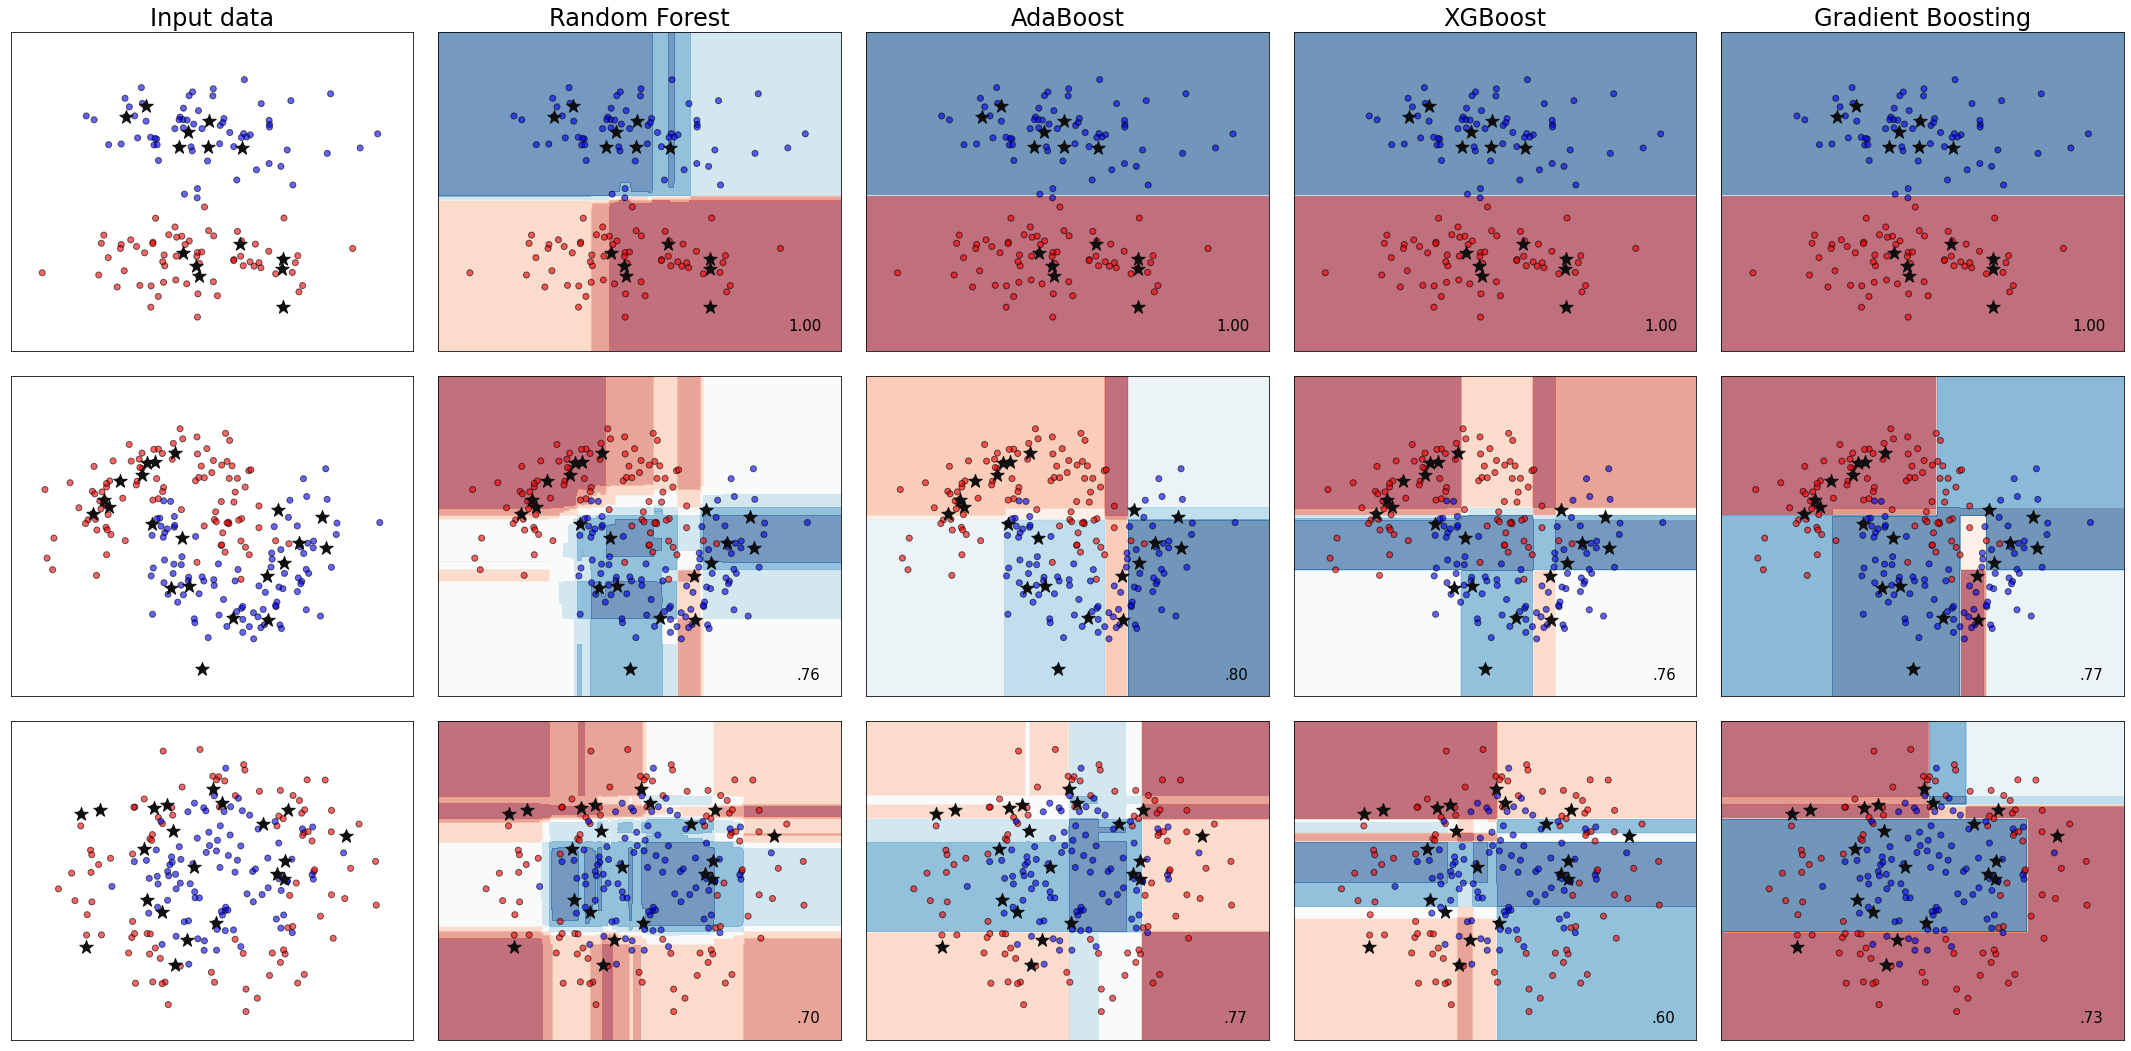

In [63]:
h = 0.02  # step size in the mesh

names = [
    "Random Forest",
    "AdaBoost",
    "XGBoost",
    "Gradient Boosting"
]

classifiers = [
    RandomForestClassifier(),
    AdaBoostClassifier(),
    xgb.XGBClassifier(silent=True, verbosity=0),
    GradientBoostingClassifier()

]

datasets = [
    make_2class(4, 300, return_X_y=True),
    make_moons(300, noise=0.3, random_state=0),
    make_circles(300, noise=0.2, factor=0.5, random_state=1)
]

figure = plt.figure(figsize=(30, 15))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    
    X_, X_val, y_,  y_val = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    
    X_train, X_test, y_train, y_test = train_test_split(
        X_, y_, test_size=0.9, random_state=42, stratify=y_
    )

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    # Plot the testing points
    ax.scatter(
        X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
    )

    plt.scatter(X_train[:,0], X_train[:,1], marker='*', c='#0F0F0F', s=200)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_val, y_val)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=0.6)

        # Plot the training points
        ax.scatter(
            X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"
        )
        # Plot the testing points
        ax.scatter(
            X_test[:, 0],
            X_test[:, 1],
            c=y_test,
            cmap=cm_bright,
            edgecolors="k",
            alpha=0.6,
        )
        
        plt.scatter(X_train[:,0], X_train[:,1], marker='*', c='#0F0F0F', s=200)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(
            xx.max() - 0.3,
            yy.min() + 0.3,
            ("%.2f" % score).lstrip("0"),
            size=15,
            horizontalalignment="right",
        )
        i += 1

plt.tight_layout()
plt.show()


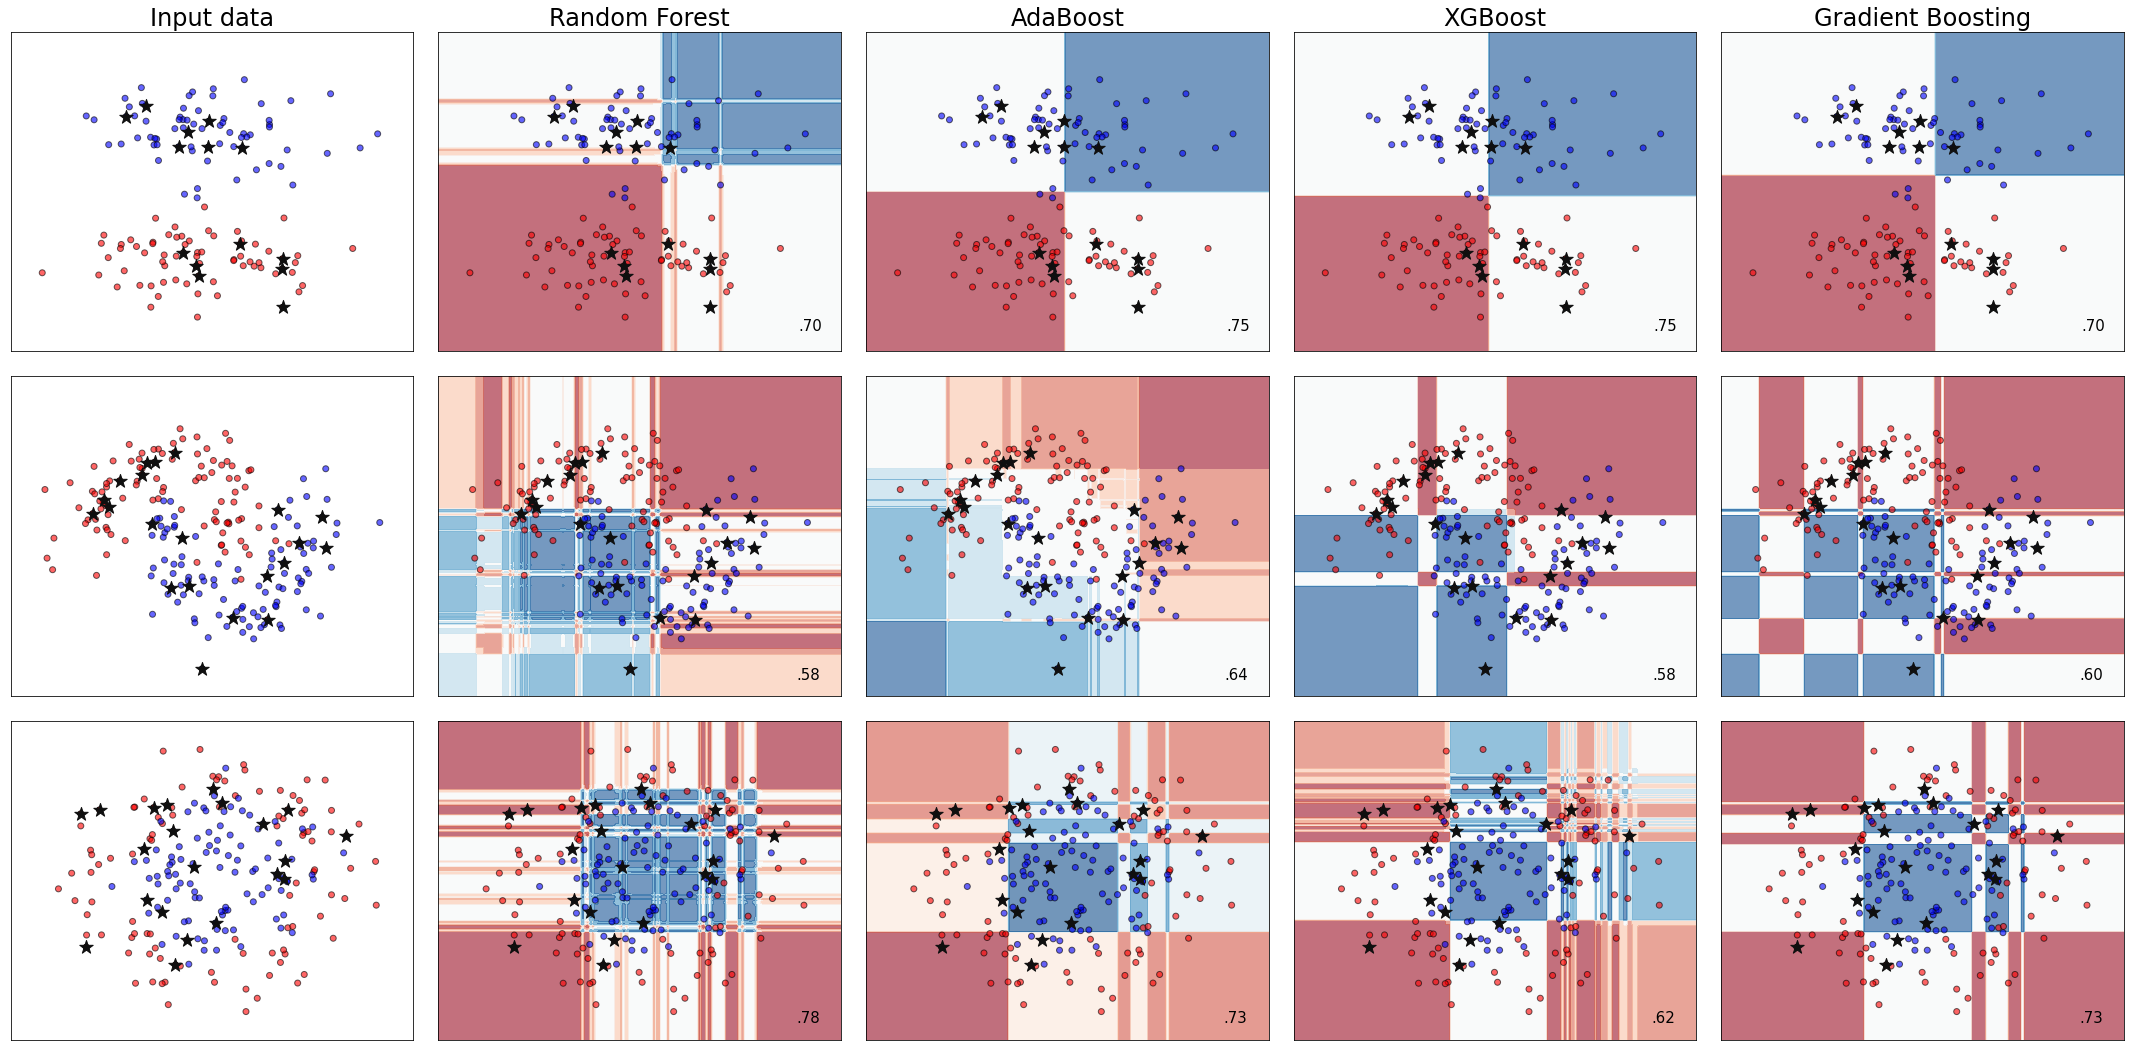

In [62]:
h = 0.02  # step size in the mesh

names = [
    "Random Forest",
    "AdaBoost",
    "XGBoost",
    "Gradient Boosting"
]

classifiers = [
    RandomForestClassifier(),
    AdaBoostClassifier(),
    xgb.XGBClassifier(silent=True, verbosity=0),
    GradientBoostingClassifier()
]

datasets = [
    make_2class(4, 300, return_X_y=True),
    make_moons(300, noise=0.3, random_state=0),
    make_circles(300, noise=0.2, factor=0.5, random_state=1)
]

figure = plt.figure(figsize=(30, 15))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    
    X_, X_val, y_,  y_val = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    
    X_train, X_test, y_train, y_test = train_test_split(
        X_, y_, test_size=0.9, random_state=42, stratify=y_
    )
    
    l_data = np.array_split(X_train, 2, axis=1)
    u_data = np.array_split(X_test, 2, axis=1)

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    # Plot the testing points
    ax.scatter(
        X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
    )

    plt.scatter(X_train[:,0], X_train[:,1], marker='*', c='#0F0F0F', s=200)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        
        spaco = SPamCo(
            labeled_data=l_data,
            unlabeled_data=u_data,
            labels=y_train,
            num_view=2,
            gamma=0.3,
            iterations=20
        )

        spaco.fit(clf)
        
        score = spaco.score(X_val, y_val)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        Z = spaco.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=0.6)

        # Plot the training points
        ax.scatter(
            X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"
        )
        # Plot the testing points
        ax.scatter(
            X_test[:, 0],
            X_test[:, 1],
            c=y_test,
            cmap=cm_bright,
            edgecolors="k",
            alpha=0.6,
        )
        
        plt.scatter(X_train[:,0], X_train[:,1], marker='*', c='#0F0F0F', s=200)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(
            xx.max() - 0.3,
            yy.min() + 0.3,
            ("%.2f" % score).lstrip("0"),
            size=15,
            horizontalalignment="right",
        )
        i += 1

plt.tight_layout()
plt.show()
